### Image data separetion 

In [2]:
import tensorflow
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

tensorflow.set_random_seed(42)
np.random.seed(42)

print(tensorflow.__version__)
print("Num GPUs Available: ", len(tensorflow.config.experimental.list_physical_devices('GPU')))

tensorflow.debugging.set_log_device_placement(True)
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
tensorflow.config.experimental.set_memory_growth(gpus[0], True)

1.15.2
Num GPUs Available:  1


In [3]:
import warnings
warnings.filterwarnings('ignore')

import os, shutil 

original_dataset_path = './data'

base_path = './melanoma_nevus'
if not os.path.isdir(base_path): os.mkdir(base_path)

# Make a new folders
train_folder = os.path.join(base_path, 'train')
if not os.path.isdir(train_folder): os.mkdir(train_folder)
validation_folder = os.path.join(base_path, 'validation')
if not os.path.isdir(validation_folder): os.mkdir(validation_folder)
test_folder = os.path.join(base_path, 'test')
if not os.path.isdir(test_folder): os.mkdir(test_folder)

train_melanoma_folder = os.path.join(train_folder, 'melanoma')
if not os.path.isdir(train_melanoma_folder): os.mkdir(train_melanoma_folder)
train_nevus_folder = os.path.join(train_folder, 'nevus')
if not os.path.isdir(train_nevus_folder): os.mkdir(train_nevus_folder)
600

validation_melanoma_folder = os.path.join(validation_folder, 'melanoma')
if not os.path.isdir(validation_melanoma_folder): os.mkdir(validation_melanoma_folder)
validation_nevus_folder = os.path.join(validation_folder, 'nevus')
if not os.path.isdir(validation_nevus_folder): os.mkdir(validation_nevus_folder)

test_melanoma_folder = os.path.join(test_folder, 'melanoma')
if not os.path.isdir(test_melanoma_folder): os.mkdir(test_melanoma_folder)
test_nevus_folder = os.path.join(test_folder, 'nevus')
if not os.path.isdir(test_nevus_folder): os.mkdir(test_nevus_folder)

In [4]:
# Get filenames for melanoma and nevus
melanoma_path = os.path.join(original_dataset_path, '1')
nevus_path = os.path.join(original_dataset_path, '0')

melanoma_filenames = [f for f in os.listdir(melanoma_path) if os.path.isfile(os.path.join(melanoma_path, f))]
nevus_filenames = [f for f in os.listdir(nevus_path) if os.path.isfile(os.path.join(nevus_path, f))]

In [5]:
# Copy images in to new folders
# split ratio (train, validation, test)
split_ratio = (0.8, 0.1, 0.1)

melanoma_src_dst = []
print("Melanoma files: {}".format(len(melanoma_filenames)))
for i in range(len(melanoma_filenames)):
    file_name = melanoma_filenames[i]
    
    src = os.path.join(melanoma_path, file_name)
    
    if i < split_ratio[0] * len(melanoma_filenames):
        # Train
        dst = os.path.join(train_melanoma_folder, file_name)
    elif i < split_ratio[0] * len(melanoma_filenames) + split_ratio[1] * len(melanoma_filenames):
        # Validation
        dst = os.path.join(validation_melanoma_folder, file_name)
    else:
        # Test
        dst = os.path.join(test_melanoma_folder, file_name)
    
    shutil.copyfile(src, dst)

nevus_src_dst = []
print("Nevus files: {}".format(len(nevus_filenames)))
for i in range(len(nevus_filenames)):
    file_name = nevus_filenames[i]
    
    src = os.path.join(nevus_path, file_name)
    
    if i < split_ratio[0] * len(nevus_filenames):
        # Train
        dst = os.path.join(train_nevus_folder, file_name)
    elif i < split_ratio[0] * len(nevus_filenames) + split_ratio[1] * len(nevus_filenames):
        # Validation
        dst = os.path.join(validation_nevus_folder, file_name)
    else:
        # Test
        dst = os.path.join(test_nevus_folder, file_name)

    shutil.copyfile(src, dst)
  
print('-'*32)
print('Melanoma train:', len(os.listdir(train_melanoma_folder)))
print('Melanoma validation:', len(os.listdir(validation_melanoma_folder)))
print('Melanoma test:', len(os.listdir(test_melanoma_folder)))
print('Nevus train:', len(os.listdir(train_nevus_folder)))
print('Nevus validation:', len(os.listdir(validation_nevus_folder)))
print('Nevus test:', len(os.listdir(test_nevus_folder)))


Melanoma files: 1000
Nevus files: 1000
--------------------------------
Melanoma train: 800
Melanoma validation: 200
Melanoma test: 200
Nevus train: 800
Nevus validation: 200
Nevus test: 200


### Make image generator

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

SIZE = (300,225)
batch_size = 40

# Rescale image values from 0..255 to 0..1
train_datagen = ImageDataGenerator(rescale=1./255,
#                                    rotation_range=10,
#                                    width_shift_range=0.1,
#                                    height_shift_range=0.1,
#                                    shear_range=0.1,
#                                    zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_folder, 
    target_size = (SIZE[0],SIZE[1]),
    batch_size = batch_size,
    class_mode = 'binary')

valid_generator = valid_datagen.flow_from_directory(
    validation_folder, 
    target_size = (SIZE[0],SIZE[1]), 
    batch_size = batch_size,
    class_mode = 'binary')

test_generator = test_datagen.flow_from_directory(
    test_folder, 
    target_size = (SIZE[0],SIZE[1]), 
    batch_size = batch_size,
    class_mode = 'binary')

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


### Network construction

In [7]:
# Plot training
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

In [8]:
# My model
model = models.Sequential()

model.add(layers.Conv2D(3, (3,3), padding='same', activation='relu', input_shape=(SIZE[0],SIZE[1],3)))
model.add(layers.MaxPooling2D((3,3)))#, strides=(2,2)))

# model.add(layers.Conv2D(4, (3,3), padding='same', activation='relu'))
# model.add(layers.MaxPooling2D((3,3)))#, strides=(2,2)))

# model.add(layers.Conv2D(8, (3,3), padding='same', activation='relu'))
# model.add(layers.MaxPooling2D((3,3), strides=(2,2)))

model.add(layers.Flatten())
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 225, 3)       84        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 75, 3)        0         
_________________________________________________________________
flatten (Flatten)            (None, 22500)             0         
_________________________________________________________________
dense (Dense)                (None, 8)                 180008    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 180,101
Trainable params: 180,101
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.w

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5

Epoch 1/40
100/100 [==============================] - 10s 98ms/step - loss: 0.7075 - acc: 0.5027 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 2/40
100/100 [==============================] - 8s 75ms/step - loss: 0.6932 - acc: 0.4995 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 3/40
100/100 [==============================] - 8s 78ms/step - loss: 0.6932 - acc: 0.5002 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 4/40
100/100 [==============================] - 8s 75ms/step - loss: 0.6932 - acc: 0.4997 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 5/40
100/100 [==============================] - 7s 73ms/step - loss: 0.6932 - acc: 0.4895 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 6/40
100/100 [==============

100/100 [==============================] - 7s 73ms/step - loss: 0.6932 - acc: 0.4902 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 37/40
100/100 [==============================] - 8s 76ms/step - loss: 0.6932 - acc: 0.5038 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 38/40
100/100 [==============================] - 7s 75ms/step - loss: 0.6932 - acc: 0.4897 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 39/40
100/100 [==============================] - 8s 76ms/step - loss: 0.6932 - acc: 0.4908 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 40/40
100/100 [==============================] - 7s 72ms/step - loss: 0.6932 - acc: 0.4918 - val_loss: 0.6931 - val_acc: 0.5000


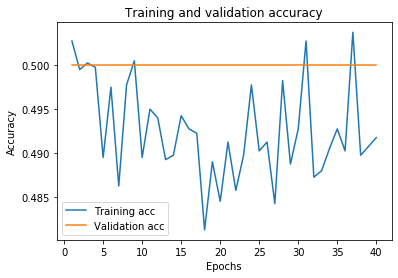

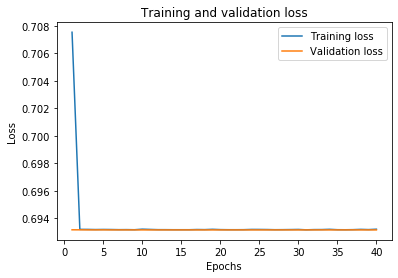

In [9]:
# callbacks_list = [
#     tensorflow.keras.callbacks.EarlyStopping(
#         monitor='val_acc', min_delta=0.001, patience=10),
#     tensorflow.keras.callbacks.ModelCheckpoint(
#         filepath='model.h5', monitor='val_loss',save_best_only=True)
# ]


history = model.fit_generator(
    train_generator,
    steps_per_epoch = 100,
    epochs = 40,
    validation_data = valid_generator,
    validation_steps = 30,
    verbose=1)

model.save('melanoma_nevus_1.h5')

plot_history(history)

In [11]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=400)
print("test acc:", test_acc)
print("test loss:", test_loss)

test acc: 0.5
test loss: 1.4887127195298673


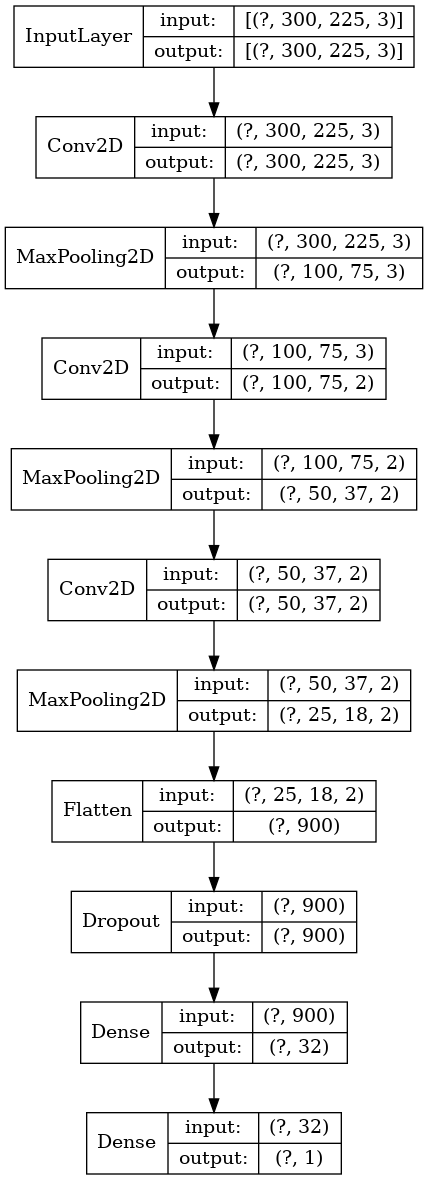

In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import pydot, pydotplus
import graphviz
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)